# Project 3

One topic that caught my eye from last week's projects was creating color-coded phylogenetic trees based on metadata that went alongside the COVID-19 sequences.  I think there is much to contribute here, so this week I decided to extend my Levenshtein-distance-based trees by color-coding them.

In the interest of also creating something useful that can adapt to current events, I decided to have this notebook pull the most recent N (defined below) sequences from the GalaxyProject, create a distance matrix using the Levenshtein distance on the entire genome, then create a phylogenetic tree color-coded by country.  My idea is that this could become a tool that people could run on a recurring basis to see changes over time between countries with the most recent data.

In [92]:
N = 20 # can get really expensive as this number increases

## Setup

In [109]:
import pandas as pd
import numpy as np
from Bio.Phylo.TreeConstruction import DistanceMatrix
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import Phylo
from Bio.SeqIO.FastaIO import SimpleFastaParser
import Levenshtein
import matplotlib.pyplot as plt
import urllib
import yaml
import matplotlib.patches as mpatches

In [11]:
%matplotlib inline

## Retrieve the genome data

In [13]:
urllib.request.urlretrieve("https://covid19.galaxyproject.org/genomics/4-Variation/current_complete_ncov_genomes.fasta", "current_genomes.fasta")

('current_genomes.fasta', <http.client.HTTPMessage at 0x1e68146cd08>)

In [38]:
sequences_df = pd.DataFrame()
with open("current_genomes.fasta") as input_file:
    ids = []
    sequences = []
    for line, sequence in SimpleFastaParser(input_file):
        ids.append(line.split(None, 1)[0])
        sequences.append(sequence)
sequences_df["id"] = ids
sequences_df["sequence"] = sequences

In [39]:
sequences_df

,id,sequence
0,MT007544.1,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...
1,MT019529.1,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...
2,MT019530.1,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...
3,MT019531.1,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...
4,MT019532.1,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...
...,...,...
816,MT350277.1,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...
817,MT350278.1,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...
818,MT350279.1,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...
819,MT350280.1,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...


## Retrieve the metadata

In [22]:
urllib.request.urlretrieve("https://www.ncbi.nlm.nih.gov/core/assets/genbank/files/ncov-sequences.yaml", "current_meta.yaml")

('current_meta.yaml', <http.client.HTTPMessage at 0x1e6834d4d88>)

In [32]:
meta_df = pd.DataFrame()
with open("current_meta.yaml") as input_file:
    ids = []
    dates = []
    countries = []
    temp = yaml.load(input_file.read())
    for data in temp["genbank-sequences"]:
        ids.append(data["accession"])
        dates.append(data["collection_date"])
        countries.append(data["country"])
meta_df["id"] = ids
meta_df["date"] = dates
meta_df["country"] = countries

meta_df["date"] = pd.to_datetime(meta_df["date"])
meta_df

C:\Users\Andrew\anaconda3\lib\site-packages\ipykernel_launcher.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


,id,date,country
0,NC_045512,2019-12-01,China
1,MN938384,2020-01-10,China: Shenzhen
2,MT039887,2020-01-31,USA: WI
3,MT039888,2020-01-29,USA: MA
4,MT184912,2020-02-17,USA
...,...,...,...
1617,MT358743,2020-04-01,USA: WA
1618,MT358748,2020-03-31,USA: WA
1619,MT359231,2020-04-01,Serbia
1620,MT359865,2020-03-15,Spain


In [49]:
def parse_country_extra(text):
    if text is not None and ":" in text:
        return "".join(text.split(":")[1:])
    return ""
def clean_country(text):
    if text is not None and ":" in text:
        return text.split(":")[0]
    return text
meta_df["country_extra"] = meta_df["country"].apply(parse_country_extra)
meta_df["country"] = meta_df["country"].apply(clean_country)

## Merge the data

In [50]:
sequences_df["id"] = sequences_df["id"].str.replace(".1", "")

In [75]:
merged_df = meta_df.merge(sequences_df, on="id")
merged_df.set_index("id", inplace=True)
merged_df

,date,country,country_extra,sequence
id,,,,
MT039887,2020-01-31,USA,WI,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...
MT039888,2020-01-29,USA,MA,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...
MT044258,2020-01-27,USA,CA,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...
MT044257,2020-01-28,USA,IL,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...
MT007544,2020-01-25,Australia,Victoria,ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGA...
...,...,...,...,...
MT308697,2020-03-11,USA,MI,CTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCT...
MT308698,2020-03-12,USA,MI,CTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGT...
MT308699,2020-03-12,USA,MI,GATCTGTTCTCTAAACGAACTTTAAAATCTGTGTGGCTGTCACTCG...


In [89]:
subset_ids = list(merged_df.sort_values("date", ascending=False).iloc[:N].index)

In [91]:
lev_distances = {}
counter = 0
for i, seqid1 in enumerate(subset_ids):
    lev_distances[seqid1,seqid1] = 0
    for j in range(i + 1, len(subset_ids)):
        seqid2 = subset_ids[j]
        lev_distances[seqid1, seqid2] = Levenshtein.distance(merged_df.loc[seqid1]["sequence"], merged_df.loc[seqid2]["sequence"])
        lev_distances[seqid2, seqid1] = lev_distances[seqid1, seqid2]
        counter += 1
        if(counter % 10 == 0):
            print(counter)
        
lev_distances = pd.Series(lev_distances).unstack()
lev_distances

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


,MT308702,MT308703,MT308704,MT345868,MT345869,MT345870,MT345873,MT345874,MT345878,MT345882,MT345883,MT345884,MT345885,MT345887,MT350246,MT350253,MT350254,MT350255,MT350256,MT350257
MT308702,0,18,17,58,76,22,79,13,53,61,8,310,72,48,35,66,77,32,13,32
MT308703,18,0,35,76,94,40,97,31,71,79,26,328,90,66,41,84,91,46,27,48
MT308704,17,35,0,75,93,39,96,30,70,78,25,323,85,61,52,83,94,49,30,49
MT345868,58,76,75,0,23,55,25,60,25,29,57,366,27,20,87,40,51,78,65,70
MT345869,76,94,93,23,0,71,21,80,43,24,75,384,47,38,74,27,38,65,83,58
MT345870,22,40,39,55,71,0,74,17,43,60,14,319,65,46,54,69,80,45,35,37
MT345873,79,97,96,25,21,74,0,83,46,28,78,387,36,43,86,39,50,77,88,69
MT345874,13,31,30,60,80,17,83,0,46,66,5,310,67,53,48,75,86,39,26,39
MT345878,53,71,70,25,43,43,46,46,0,31,45,344,30,25,87,38,49,78,66,71
MT345882,61,79,78,29,24,60,28,66,31,0,61,370,50,27,66,13,24,57,68,49


In [93]:
lev_matrix = np.tril(lev_distances.values).tolist()
for i in range(len(lev_matrix)):
    lev_matrix[i] = lev_matrix[i][:i+1]
lev_dm = DistanceMatrix(list(lev_distances.index), lev_matrix)

In [99]:
countries = merged_df["country"].unique()

In [103]:
colors = [c for c in Phylo.BaseTree.BranchColor.color_names if c not in ["white", "black"] and len(c) > 1]

In [104]:
color_legend = {}
for i in range(len(countries)):
    country = countries[i]
    color = colors[i]
    color_legend[country] = color
color_legend

{'USA': 'red',
 'Australia': 'yellow',
 'South Korea': 'green',
 'Spain': 'cyan',
 'China': 'blue',
 'India': 'magenta',
 'Nepal': 'maroon',
 'Pakistan': 'olive',
 'Peru': 'lime',
 'Israel': 'aqua',
 'Turkey': 'teal',
 'Greece': 'navy',
 'South Africa': 'fuchsia',
 'Brazil': 'purple',
 'France': 'silver'}

In [106]:
constructor = DistanceTreeConstructor()
lev_tree = constructor.nj(lev_dm)
lev_tree.ladderize()

In [107]:
for clade in lev_tree.get_terminals():
    country = merged_df.loc[clade.name]["country"]
    clade.color = color_legend[country]

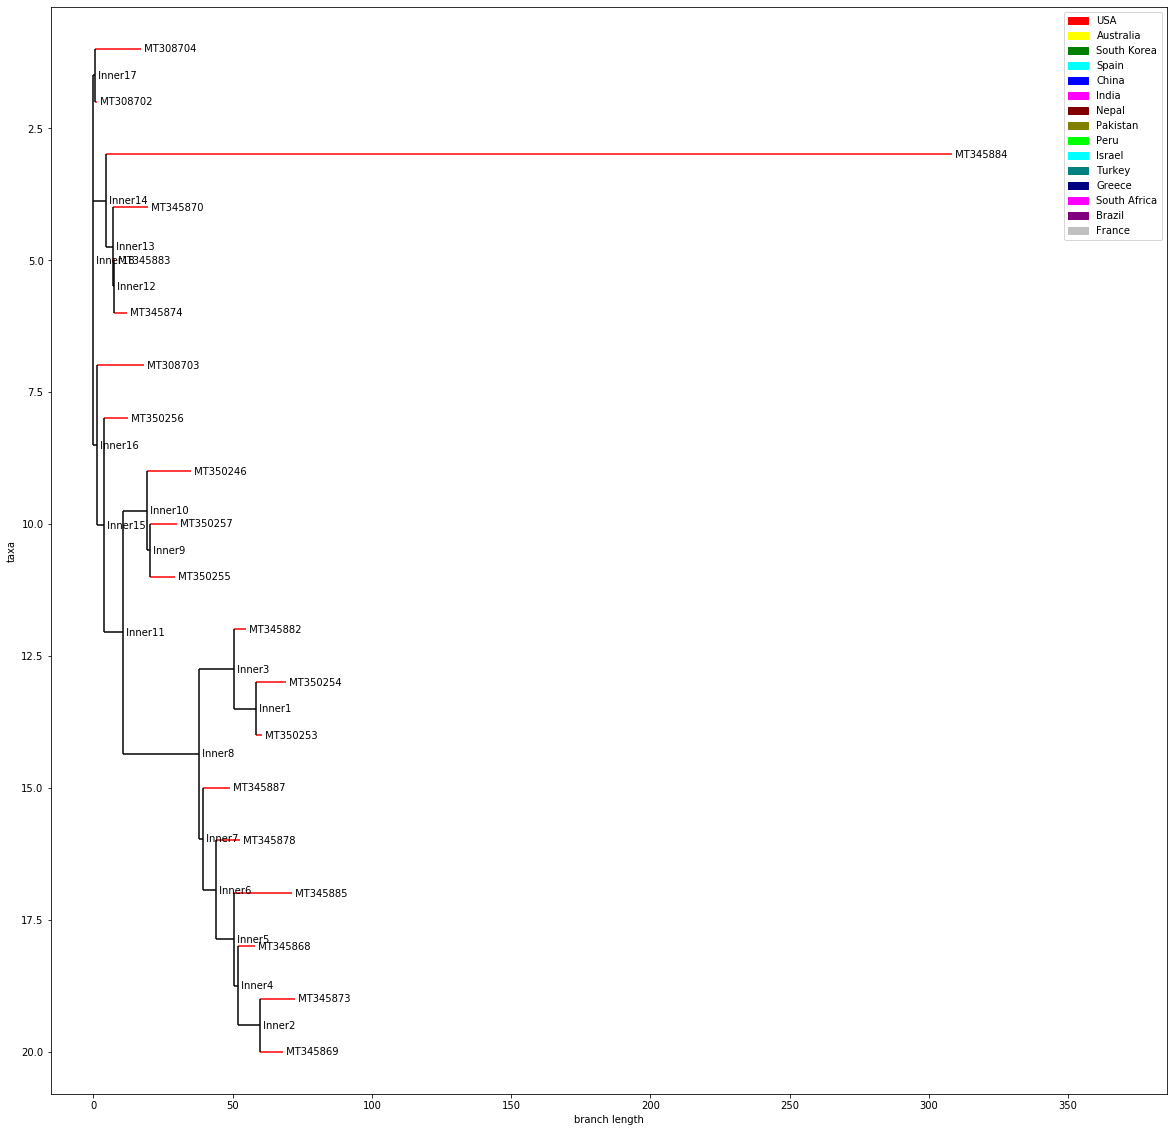

In [118]:
patches = []
for country in countries:
    patch = mpatches.Patch(color=color_legend[country], label=country)
    patches.append(patch)
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)
plt.legend(handles=patches)
Phylo.draw(lev_tree, axes=ax)

Unfortunately, it looks like all of the N most recent sequences are from the U.S. (N=20 when I ran).  This means I can't really compare different countries in my phylogenetic tree.
I really would like to run this notebook on all of the data, but since calculating the Levenshtein distance on the whole genome is expensive, I am unable to run this on much more than I did.

I would invite anyone else reading to try running this notebook with a higher N (defined at the top of the notebook) to see if we can get some interesting graphs comparing countries in the phylogenetic tree.
In the coming weeks, I will want to investigate how I can optimize or distribute this computation so that I can get a massive tree.